# imports

In [80]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import data_transforations as data_tr


In [81]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/Data2/"

## Models

In [82]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedRandomForestClassifier



## Scoring

In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Recall

In [84]:
#cross_val_score(clf, X, y, cv=5, scoring='recall')

#cv= the number of folds in cross validation

### Precision

In [85]:
#cross_val_score(clf, X, y, cv=5, scoring='precision')

### F-beta 

F1 score but you can choose the weighting between recall and precision, where f1 is 50:50

In [86]:
#fbeta_scorer = make_scorer(fbeta_score, beta=2) 
#in model fitting: scoring=fbeta_scorer
##cross_val_score(clf, X, y, cv=5, scoring=fbeta_scorer)
# beta is the ratio of recall:precision, so beta=2 means rcall2:1precision and beta =0.5 means recall1:2precision

### Functions

In [87]:
def lead_prov_grouping(prov):
    if prov in ['Recycled Freemium', 'SPL-Freemium', 'Sold Freemium','Quoted Freemium', 'ABBY Freemium', 'Freemium','CellC-Freemium']:
        return 'Freemium'
    elif prov in ['LeadWarming', 'LeadWarming TN ', 'Lead Warming']:
        return 'LeadWarming'
    elif prov in ['BLDS 101', 'BLDS']:
        return 'BLDS'
    elif prov in ['SD Phone Leads','MWL Phone Leads', 'iTalk External Call Center']:
        return 'Phone leads'
    elif prov in ['Sanlam Direct Cape Referral', 'SDC-Referral', 'MWL Referrals']:
        return 'Refferals'
    elif prov in ['Website',  'Bing', 'SD Web','MWL Web', 'Sanlam Digital','GoogleDisplay','GoogleSearch']:
        return 'Web'
    elif prov in ['MiWayLife', 'Sure_Strat_MWL','Existing Client','Reach_Republic_MWL', 'Newsletter']:
        return 'MWL'
    elif prov in ['Lead-D365-Production', 'Sanlam-Lead-D365-Production']:
        return 'D365'
    elif prov in ['Recycled','Facebook', 'Reinstatement', 'Vicidial','Wills', 'Affiliate', 'Sanlam Direct Cape', 'LiveLeads','SEO',
       'Competitions', 'SDC HIV','Olico']:
        return 'Other'
    else:
        return 'Other'


In [88]:
def data_prep(data,target,features=[],filter=None,column_excl = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag', 'policy_name','lead_provider_name','campaign_name','occupation']):

    if filter is not None:
        data = data[data[filter].notnull()].copy()
    # impute missing values
    # impute missing values
    df=DataPreparation(df=data)
    imp_dict={'optionality': 'mode',
              'occupation':'none'}
    df.imputating_nulls(imp_dict=imp_dict)
    data=df.imputed_df.copy()
    #grouping lead-provider_name
    data['lead_provider_groups']= data['lead_provider_name'].apply(lead_prov_grouping)
    data=pd.get_dummies(data,columns=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_provider_groups', 'lead_type', 'sales_channel','hiv_group', 'securitygroup_id', 'age_band',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band','underwriting_outcome'], dtype=int)
    if features == []:
        cols=set(data.columns)
        features=list(cols.difference(column_excl))
         
    X = data[features].copy()
    Y = data[target].astype(int).copy()
    # Train Test Split
    X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

    return X_train, X_test, Y_train, y_test


# Modelling

In [89]:
from sklearn.metrics import make_scorer
def my_custom_accuracy(y_true, y_pred):
    w=2
    cm = confusion_matrix(y_true, y_pred)
    true_0 =(cm[0][0]/(cm[0][0]+cm[0][1]))
    true_1= w*(cm[1][1]/(cm[1][1]+cm[1][0]))

    return (true_0+true_1)/(1+w)
custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

Target = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag']

## Data for modeling

In [98]:
imp_features=[]
target= '3month_lapse'
#filter='ann_lapse'
data=pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))
data=data.drop(columns=['Unnamed: 0'])
class_weight = {0:1,1:1}


In [99]:
data[target].sum()*100/data[target].count()

19.873746418338108

### Scaling data

In [100]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
data_s=data.copy()

In [101]:
data_s[[ 'eml','pml', 'benefits_count', 'funeral_count', 'duration_policy_start_delay', '# calls',
       '# calls contacted', 'res_code_QA_sum', 'res_code_claims_sum','res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum','res_code_update_sum', 'inflation', 'unemployment rate']] = scale.fit_transform(data_s[[ 'eml','pml', 'benefits_count', 'funeral_count', 'duration_policy_start_delay', '# calls',
       '# calls contacted', 'res_code_QA_sum', 'res_code_claims_sum','res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum','res_code_update_sum', 'inflation', 'unemployment rate']])

In [102]:
X_train,x_test, Y_train, y_test = data_prep(data_s,target)

### try resampling SMOTE

In [103]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy=0.7,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())

#X_train=X_smote.copy()
#Y_train=Y_smote.copy()

In [104]:
Y_smote.sum()*100/Y_smote.count()

41.17429534061961

### Random Forest

In [ ]:
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'n_estimators': randint(50,500),
              'min_samples_leaf': randint(700,4000),
              'class_weight': [{0:1,1:1.2},{0:1,1:4},{0:1,1:1.6},{0:1,1:8}]}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 scoring=scorer, random_state=42) #'recall',fbeta_scorer, custom_scorer

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

best score 1.0
 best eatimator RandomForestClassifier(class_weight={0: 1, 1: 8}, min_samples_leaf=3619,
                       n_estimators=201)
 best params {'class_weight': {0: 1, 1: 8}, 'min_samples_leaf': 3619, 'n_estimators': 201}
 


In [111]:
n_estimators=rand_search.best_params_['n_estimators']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
class_weight=rand_search.best_params_['class_weight']

rfc = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, random_state=42,class_weight=class_weight)
recall = cross_val_score(rfc,X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(rfc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=1.5) 
fb = cross_val_score(rfc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(rfc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb} \n custom score {cs}')




recall score [1. 1. 1. 1. 1.]
 precision score [0.41166804 0.41166804 0.41187346 0.41175262 0.41175262]
 f beta score [0.69457182 0.69457182 0.69475171 0.6946459  0.6946459 ] 
 custom score [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


In [112]:
rfc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = rfc.predict(x_test)

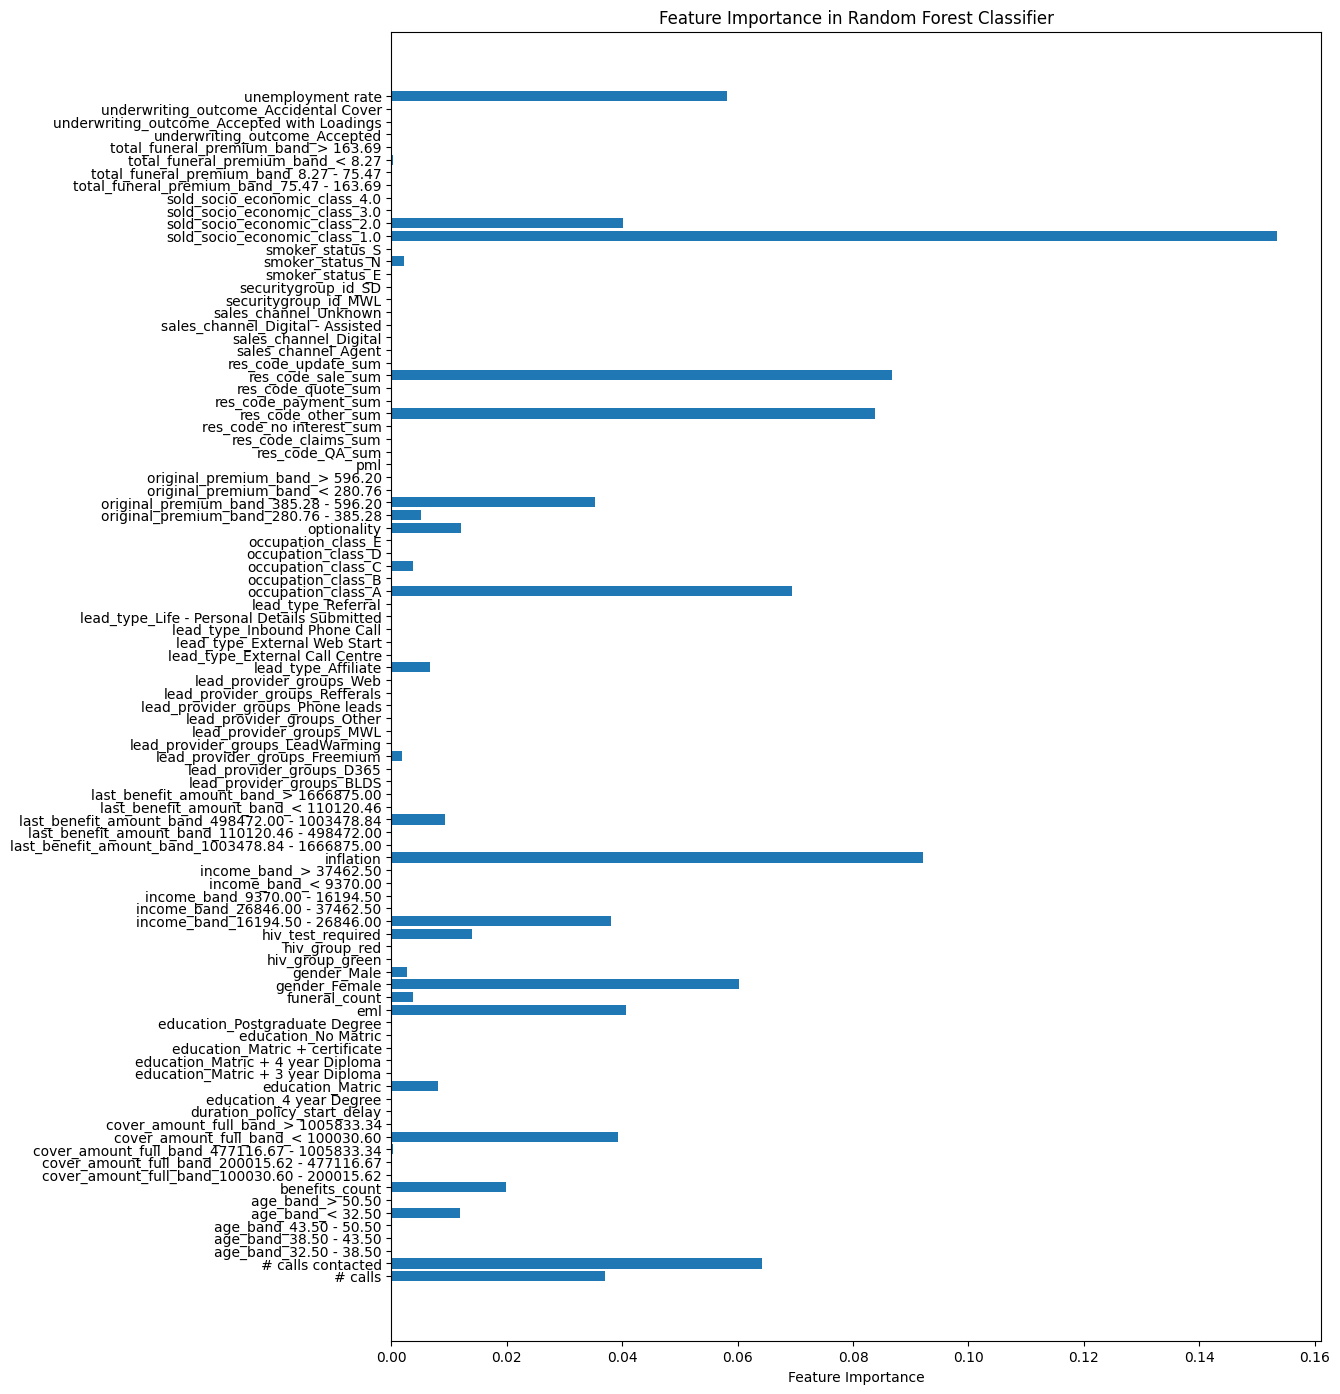

In [113]:
feature_importances =rfc.feature_importances_
feat_imp_df = pd.DataFrame({'variable':X_train_n.columns,'feat_imp': feature_importances})
feat_imp_df=feat_imp_df.sort_values(by='variable', ascending=True)
plt.figure(figsize=(12, 17)) 
plt.barh(feat_imp_df['variable'],feat_imp_df['feat_imp'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()


#useless_feat=['underwriting_outcome', securitygroup_id','sales_channel',hiv_group']

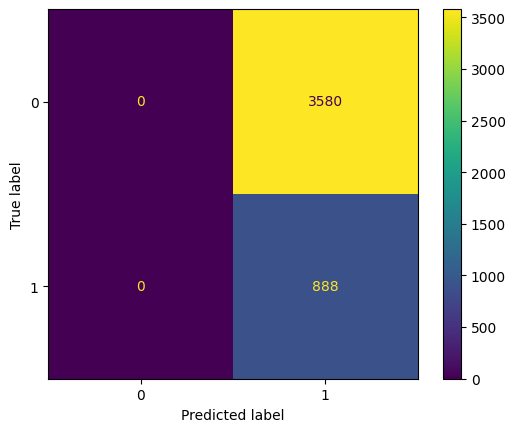

In [114]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()


### Balanced Random Forest

In [115]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [116]:
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'n_estimators': randint(50,500),
              'min_samples_leaf': randint(700,4000)}

# Create a balanced random forest classifier
brf = BalancedRandomForestClassifier(random_state=42)

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(brf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5,
                                 scoring=scorer, random_state=42) #'recall',fbeta_scorer

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p

best score 0.6907975684011997
 best eatimator BalancedRandomForestClassifier(min_samples_leaf=721, n_estimators=302,
                               random_state=42)
 best params {'min_samples_leaf': 721, 'n_estimators': 302}
 


In [117]:
n_estimators=rand_search.best_params_['n_estimators']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']

brfc = BalancedRandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, random_state=42)
recall = cross_val_score(brfc,X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(brfc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=1.5) 
fb = cross_val_score(brfc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(brfc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}\n custom score {cs}')

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p

recall score [0.44710579 0.53742515 0.81197007 0.80538922 0.80988024]
 precision score [0.56387665 0.58949097 0.63568918 0.63643533 0.64661355]
 f beta score [0.47753362 0.55243845 0.74813532 0.74457062 0.75149594]
 custom score [0.55074743 0.60432626 0.7660194  0.76291287 0.76998187]


In [118]:
brfc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = brfc.predict(x_test)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p

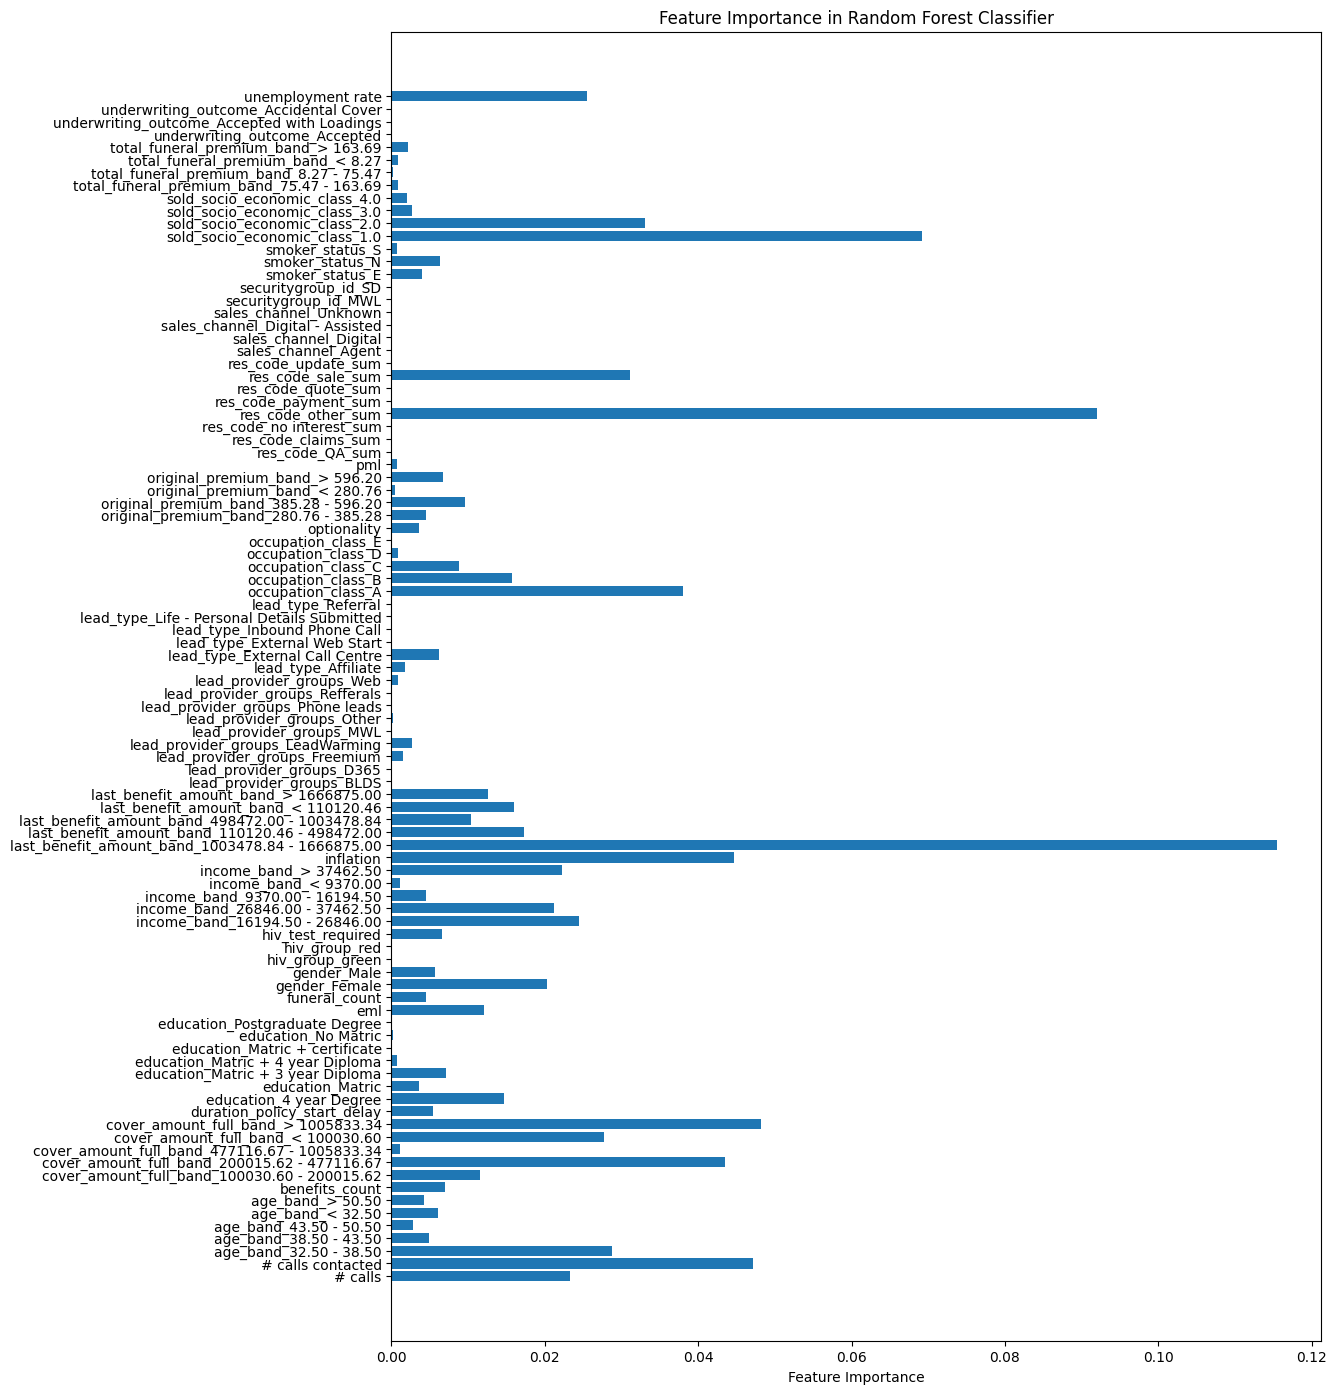

In [119]:
feature_importances =brfc.feature_importances_
feat_imp_df = pd.DataFrame({'variable':X_train_n.columns,'feat_imp': feature_importances})
feat_imp_df=feat_imp_df.sort_values(by='variable', ascending=True)
plt.figure(figsize=(12, 17)) 
plt.barh(feat_imp_df['variable'],feat_imp_df['feat_imp'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()


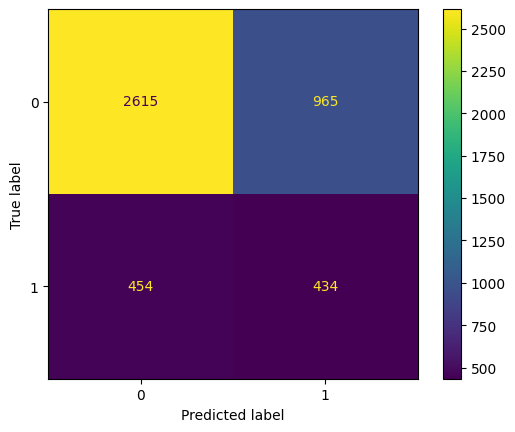

In [120]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()


### XGBoost

In [ ]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()
scorer='recall'

#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1.5
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=50,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027F9CDAE1B0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027F9CE7F140>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027F9C796780>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027F9C701AC0>},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [75]:
print(rand_search.best_params_ )
print(rand_search.best_score_)

{'learning_rate': 2, 'max_depth': 3, 'min_samples_leaf': 1563, 'n_estimators': 280}
0.2789787147336137


In [76]:
n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

recall = cross_val_score(xgbc, X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}\n custom score {cs}')

recall score [0.25505051 0.29974811 0.697733   0.26010101 0.46212121]
 precision score [0.15830721 0.14987406 0.11120032 0.17109635 0.16850829]
 f beta score [0.2146828  0.22921914 0.26601167 0.22421299 0.3008346 ]
 custom score [0.44704227 0.46234388 0.56619405 0.45437854 0.54667067]


In [77]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)


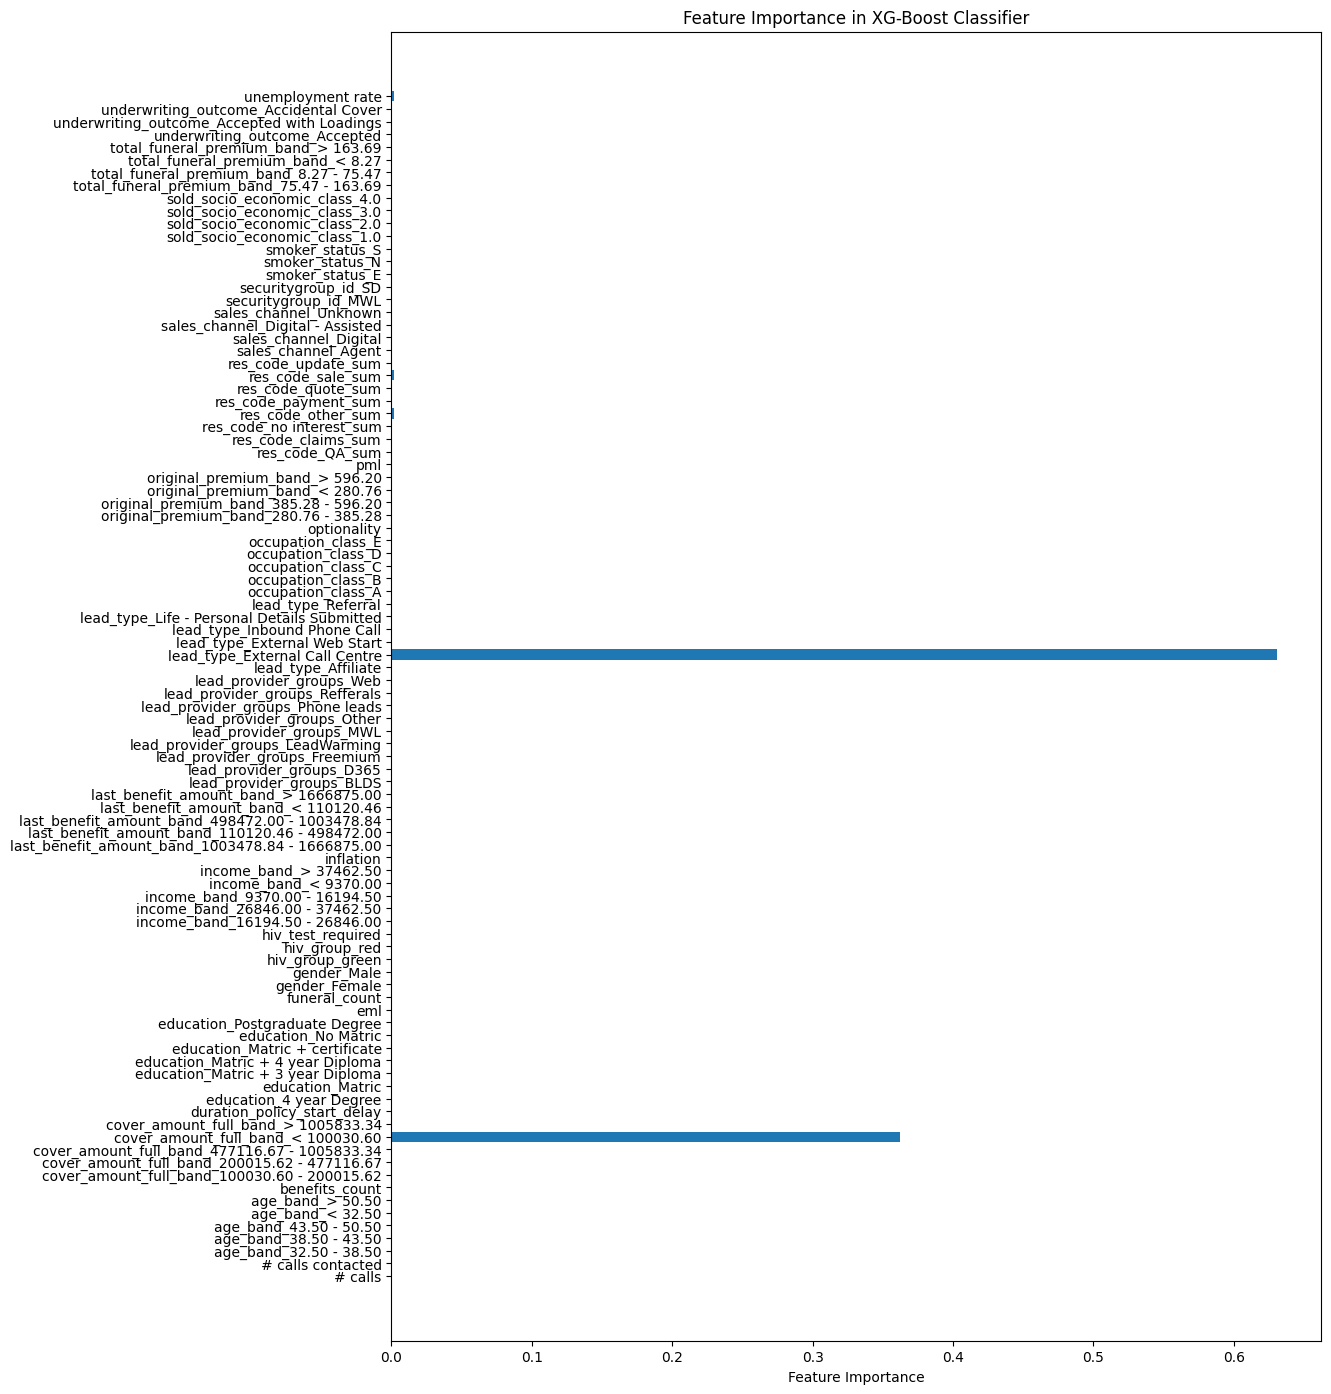

In [78]:
feature_importances =xgbc.feature_importances_
feat_imp_df = pd.DataFrame({'variable':X_train_n.columns,'feat_imp': feature_importances})
feat_imp_df=feat_imp_df.sort_values(by='variable', ascending=True)
plt.figure(figsize=(12, 17)) 
plt.barh(feat_imp_df['variable'],feat_imp_df['feat_imp'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XG-Boost Classifier')
plt.show()


#useless_feat=['securitygrup_id','sales_channel','hiv_group']

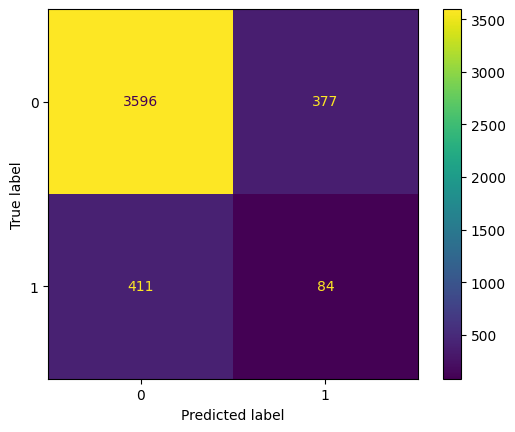

In [79]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

### Excluding inflation

In [ ]:
n_estimators=241
learning_rate = 1
max_depth = 4
min_samples_leaf=1385
xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

recall = cross_val_score(xgbc, X_train_n.drop(columns=['inflation']), Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(xgbc,X_train_n.drop(columns=['inflation']), Y_train_n, cv=5, scoring='precision')
b=4
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(xgbc,X_train_n.drop(columns=['inflation']), Y_train_n, cv=5, scoring=fbeta_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

recall score [0.56097561 0.58215661 0.56418485 0.58124599 0.5973025 ]
 precision score [0.6606198  0.68556311 0.66894977 0.68045113 0.66714491]
 f beta score [0.56599749 0.5873681  0.56943068 0.58627391 0.60100357]


### SVM

In [17]:
from scipy.stats import loguniform

In [ ]:
b=4 #ratio of recall to precision
#getting best params
param_dist = {'C': loguniform(1e-3, 1e2),
              'gamma': loguniform(1e-4, 1e-1)}

# Create a random forest classifier
sv = SVC()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(sv, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 scoring='recall', random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')







In [ ]:
gamma=0.1
C = 5
svc = SVC(gamma=gamma, C=C, random_state=42)
recall = cross_val_score(svc, X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(svc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=2) 
fb = cross_val_score(svc,X_train_n, Y_train_n, cv=5, scoring='recall')

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

recall score [0.05730479 0.78162366 0.99874135 0.99811202 0.99811083]
 precision score [0.86666667 0.93594574 0.93462898 0.93404005 0.92635885]
 f beta score [0.05730479 0.78162366 0.99874135 0.99811202 0.99811083]


In [ ]:
svc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = svc.predict(x_test)

In [ ]:
feature_importances =svc.feature_importances_
plt.figure(figsize=(12, 9)) 
plt.barh(X_train_n.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

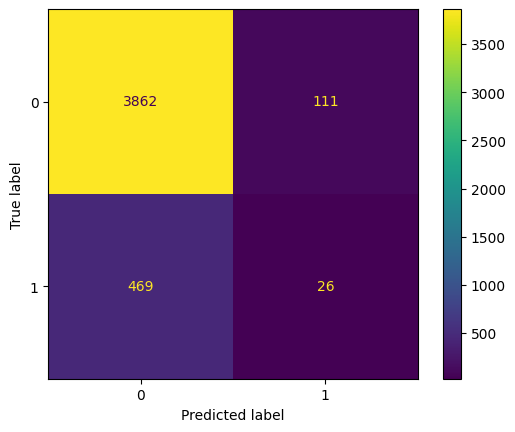

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

### NN

In [ ]:
from sklearn.neural_network import MLPClassifier

from scipy.stats import loguniform

In [ ]:
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()
scorer='recall'

b=2 #ratio of recall to precision
#getting best params
param_dist = {'solver': ['adam'],
              'alpha': loguniform(1e-5, 1e-3),
              'hidden_layer_sizes': [(15,), (20,),(15,5),(25,)],'max_iter':[1000]}


mlp = MLPClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(mlp, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5,
                                 scoring=scorer, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [ ]:
solver='adam'
alpha=rand_search.best_params_['alpha']
hidden_layer_sizes=rand_search.best_params_['hidden_layer_sizes']

mlpc = MLPClassifier(solver=solver, alpha=alpha,max_iter=1000,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=42)
recall = cross_val_score(mlpc, X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(mlpc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(mlpc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(mlpc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

In [ ]:
mlpc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = mlpc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()